<a href="https://colab.research.google.com/github/jrjoshi8848/Simple-S-P-500-Price-Prediction-with-LSTM/blob/main/s%26p_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd

### Define the ticker symbol for S&P 500


In [ ]:
ticker = "^GSPC"

### Define the start and end dates for the data

In [ ]:
import datetime
end_date = datetime.datetime.now()
start_date = end_date-datetime.timedelta(days=365)

### Download the data using yfinance

In [ ]:
download = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


### Save the data to a CSV file

In [ ]:
download.to_csv("sp500_data.csv")

### Display the first few rows of the data

In [ ]:
download.head(6)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2023-12-04 00:00:00+00:00,4569.779785,4569.779785,4572.370117,4546.720215,4564.370117,4369910000
2023-12-05 00:00:00+00:00,4567.180176,4567.180176,4578.560059,4551.680176,4557.250000,3909950000
2023-12-06 00:00:00+00:00,4549.339844,4549.339844,4590.740234,4546.500000,4586.229980,4245680000
2023-12-07 00:00:00+00:00,4585.589844,4585.589844,4590.919922,4565.220215,4568.839844,3818880000
2023-12-08 00:00:00+00:00,4604.370117,4604.370117,4609.229980,4574.060059,4576.200195,3707010000
2023-12-11 00:00:00+00:00,4622.439941,4622.439941,4623.709961,4593.390137,4593.390137,3823210000


In [ ]:
import pandas as pd

#Step 2
### Load the CSV file into a pandas DataFrame

In [ ]:
df = pd.read_csv('sp500_data.csv', skiprows=[1,2])

In [ ]:
df.head()

In [ ]:
df.rename(columns={'Price': 'Date'}, inplace=True)

In [ ]:
df.head()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [ ]:
df.head()

In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df.head()

In [ ]:
data = df.filter(['Date','Close'])

In [ ]:
data.head()

In [ ]:
data.to_csv("close.csv")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data[['Close']] = scaler.fit_transform(data[['Close']])

In [ ]:
data.head()

#Step 3

In [ ]:
data = data.sort_index()
close_values = data['Close'].values

In [ ]:
import numpy as np

### Function to create supervised learning dataset for LSTM

In [ ]:
def create_lstm_dataset(data, time_steps=60):
    """
    Transform a time series into a supervised dataset for LSTM.

    Parameters:
        data (array-like): Input time series data (e.g., Close prices).
        time_steps (int): Number of past days to use as features.

    Returns:
        X, y: Feature matrix and target array for supervised learning.
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])  # Sequence of `time_steps`
        y.append(data[i + time_steps])   # Next day's value
    return np.array(X), np.array(y)

### Step 3: Create the LSTM dataset


In [ ]:
time_steps = 60
X, y = create_lstm_dataset(close_values, time_steps)

In [ ]:
print(X,y)

###Reshaping data for LSTM

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
print(X)

In [ ]:
print(X.shape,y.shape)

(191, 60, 1) (191,)


#Step 4

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_lstm_model(input_shape):
    """
    Construct an LSTM model with the specified architecture.

    Parameters:
    input_shape (tuple): Shape of the input data (timesteps, features)

    Returns:
    tf.keras.Model: Compiled LSTM neural network model
    """
    model = Sequential([
        LSTM(50, input_shape=input_shape, return_sequences=True),
        LSTM(50),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
# Example usage:
# Define the input shape (timesteps, features), e.g., 60 days of data with 1 feature (scaled 'Close' prices)
input_shape = (60, 1)  # 60 time steps, 1 feature (Close price)
model = create_lstm_model(input_shape)
model.summary()

#Step4

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Reshape the data to be 3D for LSTM input (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Create the LSTM model using the previously defined function
input_shape = (X_train.shape[1], 1)  # 60 time steps, 1 feature
model = create_lstm_model(input_shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.2599 - val_loss: 0.1282
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0277 - val_loss: 0.0250
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0237 - val_loss: 0.0419
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0131 - val_loss: 0.0542
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0066 - val_loss: 0.0191
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0050 - val_loss: 0.0168
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0053 - val_loss: 0.0084
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0050 - val_loss: 0.0088
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0051 - val_loss: 0.0116
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0045 - val_loss: 0.0088
E

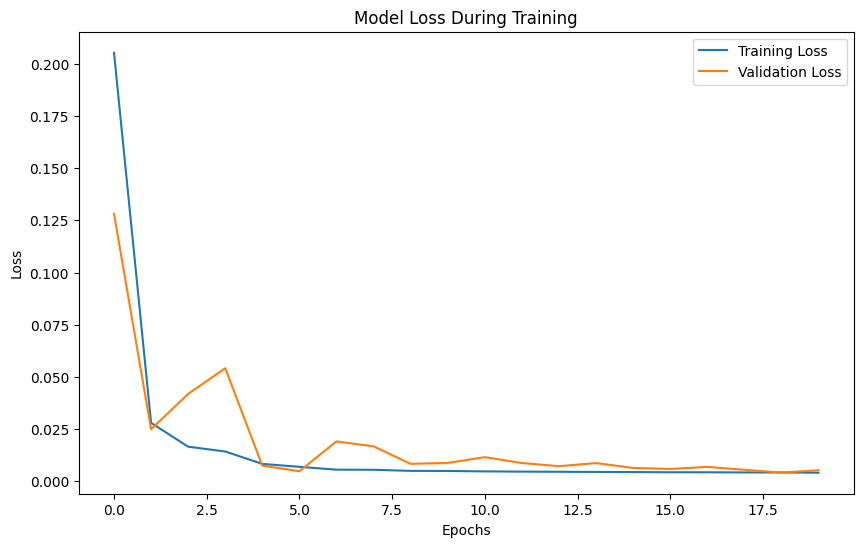

In [ ]:
# Plot the training and validation loss to monitor the training process
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the trained model weights to a file(Optional)
model.save('lstm_model.h5')
print("Model saved successfully.")

Model saved successfully.


#Step 6

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Predictions on training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


###Inverse tranforming the predicted prices

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data[['Close']])

MinMaxScaler()

In [ ]:
train_predictions_original = scaler.inverse_transform(train_predictions)
test_predictions_original = scaler.inverse_transform(test_predictions)

In [ ]:
# Inverse-transform the true values (y_train and y_test) for comparison
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


###Visulization(Optional)

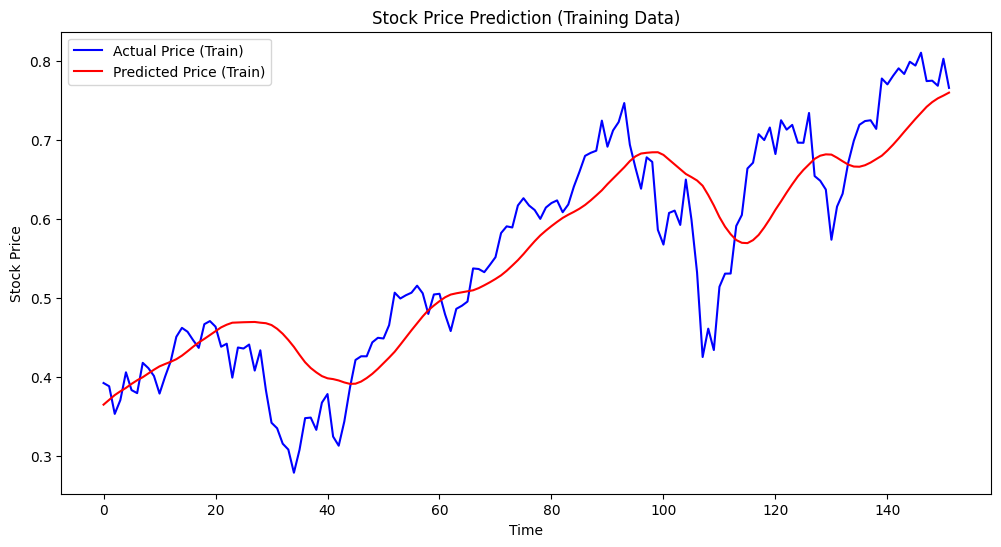

In [ ]:
# Plot the training set results
plt.figure(figsize=(12, 6))
plt.plot(y_train_original, color='blue', label='Actual Price (Train)')
plt.plot(train_predictions_original, color='red', label='Predicted Price (Train)')
plt.title('Stock Price Prediction (Training Data)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

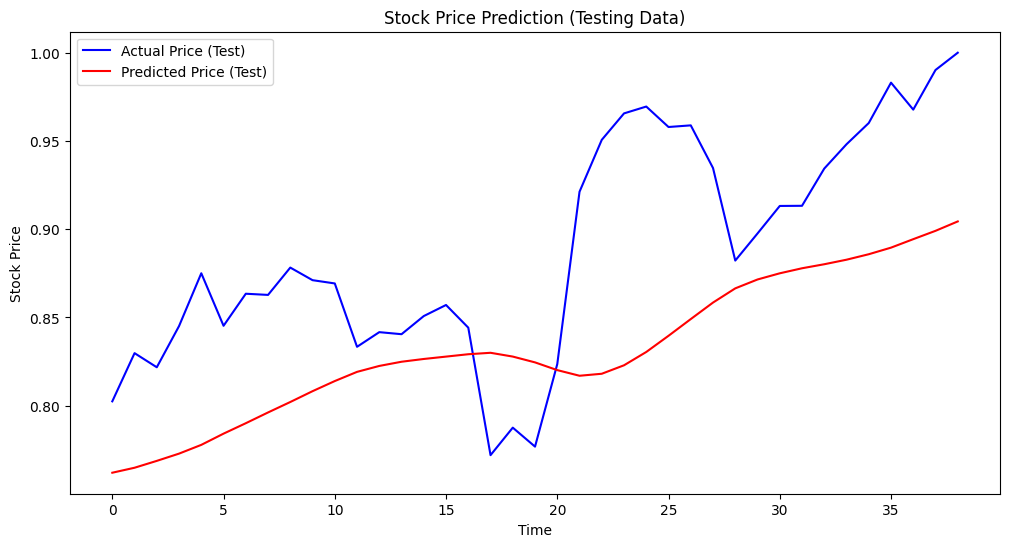

In [ ]:
# Plot the testing set results
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, color='blue', label='Actual Price (Test)')
plt.plot(test_predictions_original, color='red', label='Predicted Price (Test)')
plt.title('Stock Price Prediction (Testing Data)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#Step 7

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
recent_data = X_test[-1:]  # Get the last entry (most recent 60 days)


In [ ]:
forecasted_prices = []
for _ in range(30):
    predicted_price = model.predict(recent_data)
    predicted_price_original = scaler.inverse_transform(predicted_price)
    forecasted_prices.append(predicted_price_original[0, 0])
    recent_data = np.append(recent_data[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

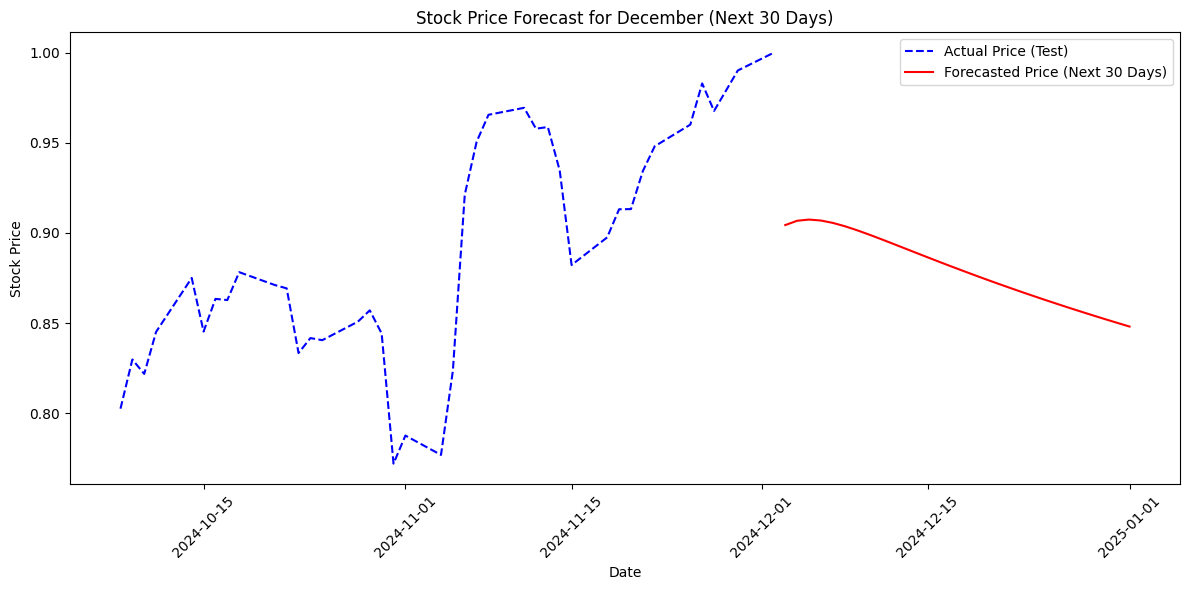

In [ ]:
# Create a time index for the forecasted period (next 30 days)
forecast_dates = pd.date_range(data.index[-1], periods=31, freq='D')[1:]

plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test_original):], y_test_original, color='blue', label='Actual Price (Test)', linestyle='--')
plt.plot(forecast_dates, forecasted_prices, color='red', label='Forecasted Price (Next 30 Days)')
plt.title('Stock Price Forecast for December (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Step 8

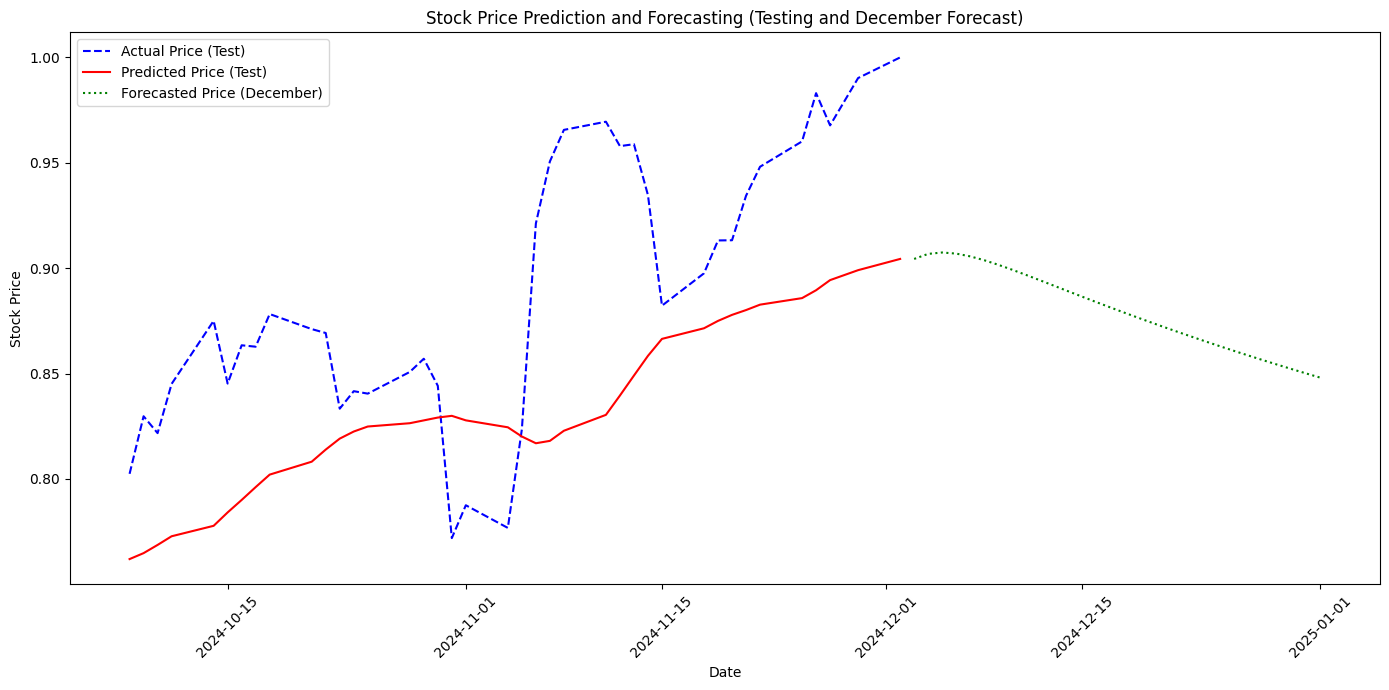

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test_original):], y_test_original, color='blue', label='Actual Price (Test)', linestyle='--')
plt.plot(data.index[-len(test_predictions_original):], test_predictions_original, color='red', label='Predicted Price (Test)')
forecast_dates = pd.date_range(data.index[-1], periods=31, freq='D')[1:]
plt.plot(forecast_dates, forecasted_prices, color='green', label='Forecasted Price (December)', linestyle=':')
plt.title('Stock Price Prediction and Forecasting (Testing and December Forecast)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Step 9


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data[['Close']])

forecasted_prices_array = np.array(forecasted_prices)
forecasted_prices_array = forecasted_prices_array.reshape(-1, 1)
print(forecasted_prices_array.shape)

forecasted_prices_original = scaler.inverse_transform(forecasted_prices_array)
forecast_df_original = pd.DataFrame({
    'Date': forecast_dates,
    'Predicted Price': forecasted_prices_original.flatten()
})
forecast_df_original.to_csv('forecast_december_original.csv', index=False)

(30, 1)
Inverse-transformed forecasted December prices saved to 'forecast_december_original.csv'.
